### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [2]:
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [3]:
import numpy as np 
import os 
import time 
import matplotlib.pyplot as plt

### Parameters

In [4]:
batch_size = 64
epochs = 5
class_size = 10
lr = 0.001

input_dim = 784
hidden_dim = 256
latent_dim = 75

### Utils functions

In [5]:
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
make_dir("./output/images")

In [7]:
def save_output_image(image, name):
    img = image.view(image.size(0), 1, 28, 28)
    save_image(img, name)

In [8]:
def onehot(idx, n=class_size):

    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)

    return onehot

### Dataloader 

In [9]:
dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor()]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)


dataloader_test = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor()]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

### Conditional Variational AutoEncoder (CVAE)

In [10]:
# Encoder class
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim , class_size):
        super().__init__()
        
        self.linear = nn.Linear(input_dim+class_size, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        hidden = torch.relu(self.linear(x))
        mean = self.mu(hidden)
        log_var = self.var(hidden)
        
        return mean, log_var
        

In [11]:
# Decoder class
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, class_size):
        super().__init__()
        
        self.latent_to_hidden = nn.Linear(latent_dim+class_size, hidden_dim)
        self.hidden_to_out = nn.Linear(hidden_dim, output_dim)
          
    def forward(self, x):
        x = F.relu(self.latent_to_hidden(x))
        x = torch.sigmoid(self.hidden_to_out(x))
        return x

In [12]:
# CAVE
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, class_size):
        super().__init__()
        
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, class_size)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, class_size)
    
    def forward(self, x, y):
        x = torch.cat((x,y), dim=1)
        z_mu, z_var = self.encoder(x)
        
        # Reparameterize
        std = torch.exp(z_var/2)
        eps = torch.randn_like(std)
        x_sample = eps*std + z_mu
        
        z = torch.cat((x_sample, y), dim=1)
        
        generated_x = self.decoder(z)
        
        return generated_x, z_mu, z_var

In [13]:
model = CVAE(input_dim, hidden_dim, latent_dim, class_size)

In [14]:
model

CVAE(
  (encoder): Encoder(
    (linear): Linear(in_features=794, out_features=256, bias=True)
    (mu): Linear(in_features=256, out_features=75, bias=True)
    (var): Linear(in_features=256, out_features=75, bias=True)
  )
  (decoder): Decoder(
    (latent_to_hidden): Linear(in_features=85, out_features=256, bias=True)
    (hidden_to_out): Linear(in_features=256, out_features=784, bias=True)
  )
)

### Optimizer and loss function

In [15]:
optimizer = optim.Adam(model.parameters(), lr=lr)

In [16]:
def calculate_loss(x, reconstructed_x, mean, log_var):
    # reconstruction loss
    RCL = F.binary_cross_entropy(reconstructed_x, x,)
    # kl divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return RCL + KLD

### Training Function

In [17]:
def train():
    model.train()

    train_loss = 0

    for i, (x, y) in enumerate(dataloader_train):
        x = x.view(-1, 28 * 28)
        x = x.to(get_device())

        y = onehot(y.view(-1, 1))
        y = y.to(get_device())

        optimizer.zero_grad()

        reconstructed_x, z_mu, z_var = model(x, y)

        loss = calculate_loss(x, reconstructed_x, z_mu, z_var)

        loss.backward()
        train_loss += loss.item()

        optimizer.step()

    return train_loss


### Evaluation Function

In [18]:
def test():
    model.eval()

    test_loss = 0

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader_test):
            x = x.view(-1, 28 * 28)
            x = x.to(get_device())

            y = onehot(y.view(-1, 1))
            y = y.to(get_device())

            reconstructed_x, z_mu, z_var = model(x, y)

            loss = calculate_loss(x, reconstructed_x, z_mu, z_var)
            test_loss += loss.item()

    return test_loss

### Training Loop

In [19]:
best_test_loss = float('inf')
for e in range(epochs):

    train_loss = train()
    test_loss = test()

    train_loss /= len(dataloader_train)
    test_loss /= len(dataloader_test)

    print(f'Epoch {e}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break


Epoch 0, Train Loss: 0.3547, Test Loss: 0.2240
Epoch 1, Train Loss: 0.2239, Test Loss: 0.2214
Epoch 2, Train Loss: 0.2227, Test Loss: 0.2209
Epoch 3, Train Loss: 0.2224, Test Loss: 0.2207
Epoch 4, Train Loss: 0.2221, Test Loss: 0.2204


Generating a 6


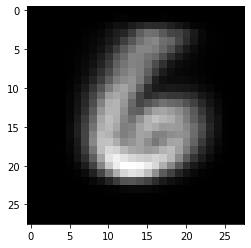

In [20]:
# create a random latent vector
z = torch.randn(1, latent_dim).to(get_device())

# pick randomly 1 class, for which we want to generate the data
y = torch.randint(0, class_size, (1, 1)).to(dtype=torch.long)
print(f'Generating a {y.item()}')

y = onehot(y).to(get_device(), dtype=z.dtype)
z = torch.cat((z, y), dim=1)

reconstructed_img = model.decoder(z)
img = reconstructed_img.view(28, 28).data

plt.figure()
plt.imshow(img, cmap='gray')
plt.show()
